In [1]:
import itertools
import numpy as np 

In [2]:
import sys
sys.path.append('../')
from SetupRewardTable import *
from visualizations import *
from ValueIteration import *

In [3]:
class SetupEpsilonTransitionWithBarrier(object):
    def __init__(self, stateSet, actionSet):
        self.stateSet = stateSet
        self.actionSet = actionSet

    def __call__(self, barrierList, epsilon=0):
        transitionTable = {state: {action:  self.getStateActionTransition(state, action, epsilon, barrierList) \
                                   for action in self.actionSet}\
                           for state in self.stateSet}
        return(transitionTable) 

    
    def getStateActionTransition(self, currentState, action, epsilon, barriers):
        
        nextState = self.getNextState(currentState, action, barriers)
        
        if currentState == nextState or epsilon == 0:
            transitionDistribution = {nextState: 1}
        else:
            transitionDistribution = {nextState: 1-epsilon, currentState:epsilon}
            
        return(transitionDistribution)

    
    def getNextState(self, state, action, barriers):
        potentialNextState = tuple([state[i] + action[i] for i in range(len(state))])
        
        if potentialNextState in self.stateSet and (not [state, potentialNextState] in barriers):
            return(potentialNextState)
        return(state) 

# Environments

In [4]:
# Actions correspond to E, N, W, S, Stay respectively
allActions = [(1,0), (0,1), (-1,0), (0,-1), (0,0)]

#all location states in grid
gridWidth = 5
gridHeight = 5
gridSet = set(itertools.product(range(gridWidth), range(gridHeight)))

#set of state-next state transitions to remove from each environment
transitionBarriers = [[(2,1),(2,2)],[(2,2), (2,1)], [(3,1), (3,2)], [(3,2), (3,1)],[(4,1), (4,2)], [(4,2), (4,1)]]

#final environment state sets
stateSetC = gridSet

#goal locations
goal1 = (0,4)
goal2 = (4,4)

#probability of ineffective action
epsilon = .1

In [5]:
getTransition = SetupEpsilonTransitionWithBarrier(stateSetC, allActions)

# possible environment transitions
exampleTransition = getTransition(transitionBarriers, 0)

In [6]:
getRewardC = SetupRewardTableWithDistanceMoveCost(exampleTransition, allActions, [goal2])
reward = getRewardC()

In [7]:
valueTable = {state:0 for state in reward.keys()}

getPolicyA = BoltzmannValueIteration(exampleTransition, reward, valueTable, 10e-7, .99, .6)
optimalValuesA, policyA = getPolicyA()

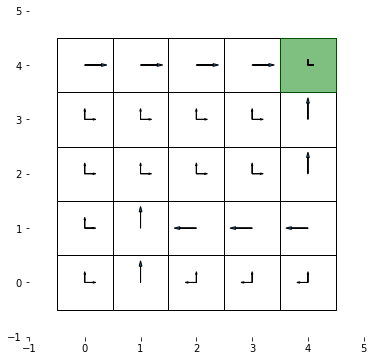

In [8]:
visualizePolicy(states=stateSetC, policy=policyA, trueGoalState=goal2, otherGoals=[], trapStates=[], arrowScale = .3)

In [9]:
policyA[(4,4)]

{(1, 0): 0.2688829002494508,
 (0, 1): 0.2688829002494508,
 (-1, 0): 0.0004146487744455296,
 (0, -1): 0.0004146487744455296,
 (0, 0): 0.46140490195220746}

In [11]:
def visualizePolicyWithBarrier(states, policy, trueGoalState, barrierList, otherGoals=[], trapStates=[], arrowScale = .3):
    #grid height/width
    gridAdjust = .5
    gridScale = 1.5
    
    minimumx, minimumy = [min(coord) for coord in zip(*states)]
    maximumx, maximumy = [max(coord) for coord in zip(*states)]
    
    plt.rcParams["figure.figsize"] = [(maximumx-minimumx)*gridScale, (maximumy-minimumy)*gridScale]
    ax = plt.gca(frameon=False, xticks = range(minimumx-1, maximumx+2), yticks = range(minimumy-1, maximumy+2))

    #gridline drawing
    for (statex, statey) in states:
        ax.add_patch(Rectangle((statex-gridAdjust, statey-gridAdjust), 1, 1, fill=False, color='black', alpha=1))

    #goal and trap coloring 
    ax.add_patch(Rectangle((trueGoalState[0]-gridAdjust, trueGoalState[1]-gridAdjust), 1, 1, fill=True, color='green', alpha=.5))

    for (goalx, goaly) in otherGoals:
        ax.add_patch(Rectangle((goalx-gridAdjust, goaly-gridAdjust), 1, 1, fill=True, color='green', alpha=.1))
    
    for (trapx, trapy) in trapStates:
        ax.add_patch(Rectangle((trapx-gridAdjust, trapy-gridAdjust), 1, 1, fill=True, color='black', alpha=.1))

    for (statex, statey), (nextStatex, nextStatey) in barrierList:
        #plt.plot([statex, nextStatex], [statey, nextStatey], color = "red")
        plt.arrow(statex, statey, (nextStatex-statex)*arrowScale, (nextStatey-statey)*arrowScale, head_width=0.05, head_length=0.1, color = 'red')
    #labeled values
    for (statex, statey), actionDict in policy.items():
        for (optimalActionX, optimalActionY), actionProb in actionDict.items():
            plt.arrow(statex, statey, optimalActionX*actionProb*arrowScale, optimalActionY*actionProb*arrowScale, head_width=0.05*actionProb, head_length=0.1*actionProb)    
    plt.show()

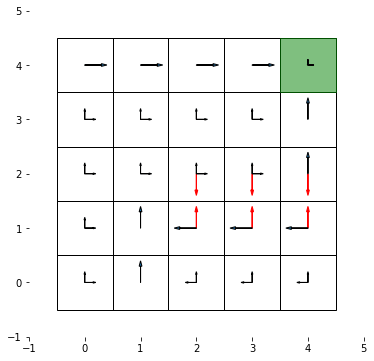

In [12]:
visualizePolicyWithBarrier(states=stateSetC, policy=policyA, trueGoalState=goal2, barrierList = transitionBarriers)